In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import Conv1DTranspose, LSTM, RepeatVector, TimeDistributed, GaussianDropout
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import random

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

from PIL import Image
import glob
import datetime

IMG_WIDTH = IMG_HEIGHT = 128

ASPHALT_PIXEL = 29
ROAD_PIXEL = 76
SAND_ROAD_PIXEL = 150

ASPHALT_CLASS = 1
ROAD_CLASS = 2
SAND_ROAD_CLASS = 3

OUTPUT_CHANNELS = 4 # 3 road classes and 1 class for rest

In [2]:
!ls ../12_07_05_20/PHOTO/Photos

200MSDCF      EOZ_lot1_WL_OPK_Hgeoid.txt   raw-202005070728-RINEX-3-03.zip
BIN	      EOZ_lot1_WL_RPY_Helips.txt   START_WL1.txt
DSC00915.JPG  EOZ_lot1_WL_RPY_Hgeoid.txt   VRS
DSC00916.JPG  raw-202005070728-RINEX-3-03  VRS.zip


In [3]:
final_img_paths =  sorted(glob.glob('../12_07_05_20/OUTPUT_PHOTOS/*'))

In [4]:
def print_message_with_time(message: str):
    print(f'[{datetime.datetime.now().strftime("%H:%M:%S")}] {message}')

def read_imgs(final_image_paths, raw_folder_path, verbose = False):
    raw_imgs = []
    final_imgs = []

    for index, final_image_path in enumerate(final_image_paths):
        if verbose:
            print_message_with_time(f"Parsing {index+1}/{len(final_image_paths)}")

        image_name = final_image_path.split('/')[-1][4:-4]
    

        raw_image_path = raw_folder_path + f'{image_name}.JPG'

        final_img = Image.open(final_image_path).convert('L')
        final_img = final_img.resize((IMG_WIDTH, IMG_HEIGHT), resample=Image.NEAREST)
        final_img = np.array(final_img)
        final_img[0,0] = 0
        final_img[0,1] = 150
        final_img[0,2] = 75
        final_img[0,3] = 30
        final_img = Image.fromarray(final_img)
        final_img = final_img.quantize(OUTPUT_CHANNELS)
        final_img = np.array(final_img)
        final_imgs.append(final_img)

        raw_img = Image.open(raw_image_path).convert('RGB')
        raw_img = raw_img.resize((IMG_WIDTH, IMG_HEIGHT))
        raw_img = np.array(raw_img)
        raw_img = raw_img / 255
        raw_imgs.append(raw_img)

    return np.array(raw_imgs), np.array(final_imgs)

raw_imgs, final_imgs = read_imgs(final_img_paths, '../12_07_05_20/PHOTO/Photos/200MSDCF/', verbose=True)

[21:35:39] Parsing 1/337
[21:35:41] Parsing 2/337
[21:35:43] Parsing 3/337
[21:35:45] Parsing 4/337
[21:35:46] Parsing 5/337
[21:35:48] Parsing 6/337
[21:35:49] Parsing 7/337
[21:35:51] Parsing 8/337
[21:35:52] Parsing 9/337
[21:35:54] Parsing 10/337
[21:35:56] Parsing 11/337
[21:35:57] Parsing 12/337
[21:35:59] Parsing 13/337
[21:36:00] Parsing 14/337
[21:36:02] Parsing 15/337
[21:36:04] Parsing 16/337
[21:36:05] Parsing 17/337
[21:36:07] Parsing 18/337
[21:36:08] Parsing 19/337
[21:36:10] Parsing 20/337
[21:36:12] Parsing 21/337
[21:36:13] Parsing 22/337
[21:36:15] Parsing 23/337
[21:36:16] Parsing 24/337
[21:36:18] Parsing 25/337
[21:36:20] Parsing 26/337
[21:36:21] Parsing 27/337
[21:36:23] Parsing 28/337
[21:36:25] Parsing 29/337
[21:36:26] Parsing 30/337
[21:36:28] Parsing 31/337
[21:36:29] Parsing 32/337
[21:36:31] Parsing 33/337
[21:36:33] Parsing 34/337
[21:36:34] Parsing 35/337
[21:36:36] Parsing 36/337
[21:36:37] Parsing 37/337
[21:36:39] Parsing 38/337
[21:36:41] Parsing 39

[21:43:55] Parsing 309/337
[21:43:56] Parsing 310/337
[21:43:58] Parsing 311/337
[21:44:00] Parsing 312/337
[21:44:02] Parsing 313/337
[21:44:03] Parsing 314/337
[21:44:05] Parsing 315/337
[21:44:06] Parsing 316/337
[21:44:08] Parsing 317/337
[21:44:09] Parsing 318/337
[21:44:11] Parsing 319/337
[21:44:13] Parsing 320/337
[21:44:14] Parsing 321/337
[21:44:16] Parsing 322/337
[21:44:17] Parsing 323/337
[21:44:19] Parsing 324/337
[21:44:21] Parsing 325/337
[21:44:22] Parsing 326/337
[21:44:24] Parsing 327/337
[21:44:26] Parsing 328/337
[21:44:27] Parsing 329/337
[21:44:29] Parsing 330/337
[21:44:30] Parsing 331/337
[21:44:32] Parsing 332/337
[21:44:34] Parsing 333/337
[21:44:35] Parsing 334/337
[21:44:37] Parsing 335/337
[21:44:38] Parsing 336/337
[21:44:40] Parsing 337/337


In [5]:
final_img_paths_2 = sorted(glob.glob('../5_09_07_19/OUTPUT_PHOTOS/*'))
raw_imgs_2, final_imgs_2 = read_imgs(final_img_paths_2, '../5_09_07_19/PHOTO/Photos/200MSDCF/', verbose=True)

[21:56:01] Parsing 1/1237
[21:56:02] Parsing 2/1237
[21:56:03] Parsing 3/1237
[21:56:04] Parsing 4/1237
[21:56:04] Parsing 5/1237
[21:56:05] Parsing 6/1237
[21:56:06] Parsing 7/1237
[21:56:07] Parsing 8/1237
[21:56:07] Parsing 9/1237
[21:56:08] Parsing 10/1237
[21:56:09] Parsing 11/1237
[21:56:10] Parsing 12/1237
[21:56:10] Parsing 13/1237
[21:56:11] Parsing 14/1237
[21:56:12] Parsing 15/1237
[21:56:13] Parsing 16/1237
[21:56:13] Parsing 17/1237
[21:56:14] Parsing 18/1237
[21:56:15] Parsing 19/1237
[21:56:15] Parsing 20/1237
[21:56:16] Parsing 21/1237
[21:56:17] Parsing 22/1237
[21:56:18] Parsing 23/1237
[21:56:18] Parsing 24/1237
[21:56:19] Parsing 25/1237
[21:56:20] Parsing 26/1237
[21:56:20] Parsing 27/1237
[21:56:21] Parsing 28/1237
[21:56:22] Parsing 29/1237
[21:56:23] Parsing 30/1237
[21:56:23] Parsing 31/1237
[21:56:24] Parsing 32/1237
[21:56:25] Parsing 33/1237
[21:56:26] Parsing 34/1237
[21:56:26] Parsing 35/1237
[21:56:27] Parsing 36/1237
[21:56:28] Parsing 37/1237
[21:56:29]

[21:59:46] Parsing 298/1237
[21:59:47] Parsing 299/1237
[21:59:48] Parsing 300/1237
[21:59:49] Parsing 301/1237
[21:59:50] Parsing 302/1237
[21:59:50] Parsing 303/1237
[21:59:51] Parsing 304/1237
[21:59:52] Parsing 305/1237
[21:59:53] Parsing 306/1237
[21:59:54] Parsing 307/1237
[21:59:54] Parsing 308/1237
[21:59:55] Parsing 309/1237
[21:59:56] Parsing 310/1237
[21:59:57] Parsing 311/1237
[21:59:58] Parsing 312/1237
[21:59:58] Parsing 313/1237
[21:59:59] Parsing 314/1237
[22:00:00] Parsing 315/1237
[22:00:01] Parsing 316/1237
[22:00:02] Parsing 317/1237
[22:00:02] Parsing 318/1237
[22:00:03] Parsing 319/1237
[22:00:04] Parsing 320/1237
[22:00:05] Parsing 321/1237
[22:00:06] Parsing 322/1237
[22:00:07] Parsing 323/1237
[22:00:07] Parsing 324/1237
[22:00:08] Parsing 325/1237
[22:00:09] Parsing 326/1237
[22:00:10] Parsing 327/1237
[22:00:11] Parsing 328/1237
[22:00:11] Parsing 329/1237
[22:00:12] Parsing 330/1237
[22:00:13] Parsing 331/1237
[22:00:14] Parsing 332/1237
[22:00:15] Parsing 3

[22:03:40] Parsing 591/1237
[22:03:41] Parsing 592/1237
[22:03:42] Parsing 593/1237
[22:03:43] Parsing 594/1237
[22:03:43] Parsing 595/1237
[22:03:44] Parsing 596/1237
[22:03:45] Parsing 597/1237
[22:03:46] Parsing 598/1237
[22:03:47] Parsing 599/1237
[22:03:47] Parsing 600/1237
[22:03:48] Parsing 601/1237
[22:03:49] Parsing 602/1237
[22:03:50] Parsing 603/1237
[22:03:51] Parsing 604/1237
[22:03:52] Parsing 605/1237
[22:03:52] Parsing 606/1237
[22:03:53] Parsing 607/1237
[22:03:54] Parsing 608/1237
[22:03:55] Parsing 609/1237
[22:03:56] Parsing 610/1237
[22:03:57] Parsing 611/1237
[22:03:57] Parsing 612/1237
[22:03:58] Parsing 613/1237
[22:03:59] Parsing 614/1237
[22:04:00] Parsing 615/1237
[22:04:01] Parsing 616/1237
[22:04:01] Parsing 617/1237
[22:04:02] Parsing 618/1237
[22:04:03] Parsing 619/1237
[22:04:04] Parsing 620/1237
[22:04:05] Parsing 621/1237
[22:04:06] Parsing 622/1237
[22:04:06] Parsing 623/1237
[22:04:07] Parsing 624/1237
[22:04:08] Parsing 625/1237
[22:04:09] Parsing 6

[22:07:33] Parsing 884/1237
[22:07:34] Parsing 885/1237
[22:07:35] Parsing 886/1237
[22:07:36] Parsing 887/1237
[22:07:37] Parsing 888/1237
[22:07:37] Parsing 889/1237
[22:07:38] Parsing 890/1237
[22:07:39] Parsing 891/1237
[22:07:40] Parsing 892/1237
[22:07:41] Parsing 893/1237
[22:07:41] Parsing 894/1237
[22:07:42] Parsing 895/1237
[22:07:43] Parsing 896/1237
[22:07:44] Parsing 897/1237
[22:07:45] Parsing 898/1237
[22:07:46] Parsing 899/1237
[22:07:46] Parsing 900/1237
[22:07:47] Parsing 901/1237
[22:07:48] Parsing 902/1237
[22:07:49] Parsing 903/1237
[22:07:50] Parsing 904/1237
[22:07:50] Parsing 905/1237
[22:07:51] Parsing 906/1237
[22:07:52] Parsing 907/1237
[22:07:53] Parsing 908/1237
[22:07:54] Parsing 909/1237
[22:07:54] Parsing 910/1237
[22:07:55] Parsing 911/1237
[22:07:56] Parsing 912/1237
[22:07:57] Parsing 913/1237
[22:07:57] Parsing 914/1237
[22:07:58] Parsing 915/1237
[22:07:59] Parsing 916/1237
[22:08:00] Parsing 917/1237
[22:08:01] Parsing 918/1237
[22:08:01] Parsing 9

[22:11:21] Parsing 1171/1237
[22:11:22] Parsing 1172/1237
[22:11:23] Parsing 1173/1237
[22:11:24] Parsing 1174/1237
[22:11:24] Parsing 1175/1237
[22:11:25] Parsing 1176/1237
[22:11:26] Parsing 1177/1237
[22:11:27] Parsing 1178/1237
[22:11:28] Parsing 1179/1237
[22:11:28] Parsing 1180/1237
[22:11:29] Parsing 1181/1237
[22:11:30] Parsing 1182/1237
[22:11:31] Parsing 1183/1237
[22:11:31] Parsing 1184/1237
[22:11:32] Parsing 1185/1237
[22:11:33] Parsing 1186/1237
[22:11:34] Parsing 1187/1237
[22:11:34] Parsing 1188/1237
[22:11:35] Parsing 1189/1237
[22:11:36] Parsing 1190/1237
[22:11:37] Parsing 1191/1237
[22:11:38] Parsing 1192/1237
[22:11:38] Parsing 1193/1237
[22:11:39] Parsing 1194/1237
[22:11:40] Parsing 1195/1237
[22:11:41] Parsing 1196/1237
[22:11:41] Parsing 1197/1237
[22:11:42] Parsing 1198/1237
[22:11:43] Parsing 1199/1237
[22:11:44] Parsing 1200/1237
[22:11:44] Parsing 1201/1237
[22:11:45] Parsing 1202/1237
[22:11:46] Parsing 1203/1237
[22:11:47] Parsing 1204/1237
[22:11:48] Par

In [6]:
final_img_paths_3 = sorted(glob.glob('../6_19_08_19/OUTPUT_PHOTOS/*'))
raw_imgs_3, final_imgs_3 = read_imgs(final_img_paths_3, '../6_19_08_19/PHOTO/Photos/200MSDCF/', verbose=True)

[22:12:14] Parsing 1/1293
[22:12:15] Parsing 2/1293
[22:12:15] Parsing 3/1293
[22:12:16] Parsing 4/1293
[22:12:17] Parsing 5/1293
[22:12:17] Parsing 6/1293
[22:12:18] Parsing 7/1293
[22:12:19] Parsing 8/1293
[22:12:20] Parsing 9/1293
[22:12:20] Parsing 10/1293
[22:12:21] Parsing 11/1293
[22:12:22] Parsing 12/1293
[22:12:22] Parsing 13/1293
[22:12:23] Parsing 14/1293
[22:12:24] Parsing 15/1293
[22:12:24] Parsing 16/1293
[22:12:25] Parsing 17/1293
[22:12:26] Parsing 18/1293
[22:12:27] Parsing 19/1293
[22:12:27] Parsing 20/1293
[22:12:28] Parsing 21/1293
[22:12:29] Parsing 22/1293
[22:12:29] Parsing 23/1293
[22:12:30] Parsing 24/1293
[22:12:31] Parsing 25/1293
[22:12:31] Parsing 26/1293
[22:12:32] Parsing 27/1293
[22:12:33] Parsing 28/1293
[22:12:34] Parsing 29/1293
[22:12:34] Parsing 30/1293
[22:12:35] Parsing 31/1293
[22:12:36] Parsing 32/1293
[22:12:36] Parsing 33/1293
[22:12:37] Parsing 34/1293
[22:12:38] Parsing 35/1293
[22:12:39] Parsing 36/1293
[22:12:39] Parsing 37/1293
[22:12:40]

[22:15:43] Parsing 298/1293
[22:15:44] Parsing 299/1293
[22:15:45] Parsing 300/1293
[22:15:46] Parsing 301/1293
[22:15:46] Parsing 302/1293
[22:15:47] Parsing 303/1293
[22:15:48] Parsing 304/1293
[22:15:48] Parsing 305/1293
[22:15:49] Parsing 306/1293
[22:15:50] Parsing 307/1293
[22:15:51] Parsing 308/1293
[22:15:51] Parsing 309/1293
[22:15:52] Parsing 310/1293
[22:15:53] Parsing 311/1293
[22:15:53] Parsing 312/1293
[22:15:54] Parsing 313/1293
[22:15:55] Parsing 314/1293
[22:15:56] Parsing 315/1293
[22:15:56] Parsing 316/1293
[22:15:57] Parsing 317/1293
[22:15:58] Parsing 318/1293
[22:15:59] Parsing 319/1293
[22:15:59] Parsing 320/1293
[22:16:00] Parsing 321/1293
[22:16:01] Parsing 322/1293
[22:16:01] Parsing 323/1293
[22:16:02] Parsing 324/1293
[22:16:03] Parsing 325/1293
[22:16:03] Parsing 326/1293
[22:16:04] Parsing 327/1293
[22:16:05] Parsing 328/1293
[22:16:05] Parsing 329/1293
[22:16:06] Parsing 330/1293
[22:16:07] Parsing 331/1293
[22:16:08] Parsing 332/1293
[22:16:08] Parsing 3

[22:19:08] Parsing 591/1293
[22:19:09] Parsing 592/1293
[22:19:10] Parsing 593/1293
[22:19:10] Parsing 594/1293
[22:19:11] Parsing 595/1293
[22:19:12] Parsing 596/1293
[22:19:12] Parsing 597/1293
[22:19:13] Parsing 598/1293
[22:19:14] Parsing 599/1293
[22:19:14] Parsing 600/1293
[22:19:15] Parsing 601/1293
[22:19:16] Parsing 602/1293
[22:19:16] Parsing 603/1293
[22:19:17] Parsing 604/1293
[22:19:18] Parsing 605/1293
[22:19:18] Parsing 606/1293
[22:19:19] Parsing 607/1293
[22:19:20] Parsing 608/1293
[22:19:21] Parsing 609/1293
[22:19:21] Parsing 610/1293
[22:19:22] Parsing 611/1293
[22:19:23] Parsing 612/1293
[22:19:24] Parsing 613/1293
[22:19:24] Parsing 614/1293
[22:19:25] Parsing 615/1293
[22:19:26] Parsing 616/1293
[22:19:26] Parsing 617/1293
[22:19:27] Parsing 618/1293
[22:19:28] Parsing 619/1293
[22:19:28] Parsing 620/1293
[22:19:29] Parsing 621/1293
[22:19:30] Parsing 622/1293
[22:19:31] Parsing 623/1293
[22:19:31] Parsing 624/1293
[22:19:32] Parsing 625/1293
[22:19:33] Parsing 6

[22:22:33] Parsing 884/1293
[22:22:33] Parsing 885/1293
[22:22:34] Parsing 886/1293
[22:22:35] Parsing 887/1293
[22:22:36] Parsing 888/1293
[22:22:36] Parsing 889/1293
[22:22:37] Parsing 890/1293
[22:22:38] Parsing 891/1293
[22:22:38] Parsing 892/1293
[22:22:39] Parsing 893/1293
[22:22:40] Parsing 894/1293
[22:22:40] Parsing 895/1293
[22:22:41] Parsing 896/1293
[22:22:42] Parsing 897/1293
[22:22:42] Parsing 898/1293
[22:22:43] Parsing 899/1293
[22:22:44] Parsing 900/1293
[22:22:45] Parsing 901/1293
[22:22:45] Parsing 902/1293
[22:22:46] Parsing 903/1293
[22:22:47] Parsing 904/1293
[22:22:47] Parsing 905/1293
[22:22:48] Parsing 906/1293
[22:22:49] Parsing 907/1293
[22:22:49] Parsing 908/1293
[22:22:50] Parsing 909/1293
[22:22:51] Parsing 910/1293
[22:22:51] Parsing 911/1293
[22:22:52] Parsing 912/1293
[22:22:53] Parsing 913/1293
[22:22:54] Parsing 914/1293
[22:22:54] Parsing 915/1293
[22:22:55] Parsing 916/1293
[22:22:56] Parsing 917/1293
[22:22:56] Parsing 918/1293
[22:22:57] Parsing 9

[22:26:02] Parsing 1171/1293
[22:26:03] Parsing 1172/1293
[22:26:04] Parsing 1173/1293
[22:26:05] Parsing 1174/1293
[22:26:05] Parsing 1175/1293
[22:26:06] Parsing 1176/1293
[22:26:07] Parsing 1177/1293
[22:26:08] Parsing 1178/1293
[22:26:08] Parsing 1179/1293
[22:26:09] Parsing 1180/1293
[22:26:10] Parsing 1181/1293
[22:26:11] Parsing 1182/1293
[22:26:12] Parsing 1183/1293
[22:26:12] Parsing 1184/1293
[22:26:13] Parsing 1185/1293
[22:26:14] Parsing 1186/1293
[22:26:15] Parsing 1187/1293
[22:26:15] Parsing 1188/1293
[22:26:16] Parsing 1189/1293
[22:26:17] Parsing 1190/1293
[22:26:18] Parsing 1191/1293
[22:26:19] Parsing 1192/1293
[22:26:20] Parsing 1193/1293
[22:26:20] Parsing 1194/1293
[22:26:21] Parsing 1195/1293
[22:26:22] Parsing 1196/1293
[22:26:23] Parsing 1197/1293
[22:26:23] Parsing 1198/1293
[22:26:24] Parsing 1199/1293
[22:26:25] Parsing 1200/1293
[22:26:26] Parsing 1201/1293
[22:26:26] Parsing 1202/1293
[22:26:27] Parsing 1203/1293
[22:26:28] Parsing 1204/1293
[22:26:29] Par

In [7]:
final_img_paths_4 = sorted(glob.glob('../8_08_11_19/OUTPUT_PHOTOS/*'))
raw_imgs_4, final_imgs_4 = read_imgs(final_img_paths_4, '../8_08_11_19/PHOTO/Photos/200MSDCF/', verbose=True)

[22:27:40] Parsing 1/270
[22:27:41] Parsing 2/270
[22:27:42] Parsing 3/270
[22:27:42] Parsing 4/270
[22:27:43] Parsing 5/270
[22:27:44] Parsing 6/270
[22:27:45] Parsing 7/270
[22:27:45] Parsing 8/270
[22:27:46] Parsing 9/270
[22:27:47] Parsing 10/270
[22:27:47] Parsing 11/270
[22:27:48] Parsing 12/270
[22:27:49] Parsing 13/270
[22:27:49] Parsing 14/270
[22:27:50] Parsing 15/270
[22:27:51] Parsing 16/270
[22:27:51] Parsing 17/270
[22:27:52] Parsing 18/270
[22:27:53] Parsing 19/270
[22:27:54] Parsing 20/270
[22:27:54] Parsing 21/270
[22:27:55] Parsing 22/270
[22:27:56] Parsing 23/270
[22:27:56] Parsing 24/270
[22:27:57] Parsing 25/270
[22:27:58] Parsing 26/270
[22:27:59] Parsing 27/270
[22:27:59] Parsing 28/270
[22:28:00] Parsing 29/270
[22:28:01] Parsing 30/270
[22:28:01] Parsing 31/270
[22:28:02] Parsing 32/270
[22:28:03] Parsing 33/270
[22:28:03] Parsing 34/270
[22:28:04] Parsing 35/270
[22:28:05] Parsing 36/270
[22:28:05] Parsing 37/270
[22:28:06] Parsing 38/270
[22:28:07] Parsing 39

In [8]:

final_img_paths_5 = sorted(glob.glob('../10_03_02_20/OUTPUT_PHOTOS/*'))
raw_imgs_5, final_imgs_5 = read_imgs(final_img_paths_5, '../10_03_02_20/PHOTO/Photos/200MSDCF/', verbose=True)

[22:30:51] Parsing 1/55
[22:30:52] Parsing 2/55
[22:30:52] Parsing 3/55
[22:30:53] Parsing 4/55
[22:30:54] Parsing 5/55
[22:30:55] Parsing 6/55
[22:30:55] Parsing 7/55
[22:30:56] Parsing 8/55
[22:30:57] Parsing 9/55
[22:30:57] Parsing 10/55
[22:30:58] Parsing 11/55
[22:30:59] Parsing 12/55
[22:30:59] Parsing 13/55
[22:31:00] Parsing 14/55
[22:31:01] Parsing 15/55
[22:31:01] Parsing 16/55
[22:31:02] Parsing 17/55
[22:31:03] Parsing 18/55
[22:31:03] Parsing 19/55
[22:31:04] Parsing 20/55
[22:31:05] Parsing 21/55
[22:31:05] Parsing 22/55
[22:31:06] Parsing 23/55
[22:31:07] Parsing 24/55
[22:31:08] Parsing 25/55
[22:31:08] Parsing 26/55
[22:31:09] Parsing 27/55
[22:31:10] Parsing 28/55
[22:31:10] Parsing 29/55
[22:31:11] Parsing 30/55
[22:31:12] Parsing 31/55
[22:31:12] Parsing 32/55
[22:31:13] Parsing 33/55
[22:31:14] Parsing 34/55
[22:31:14] Parsing 35/55
[22:31:15] Parsing 36/55
[22:31:16] Parsing 37/55
[22:31:16] Parsing 38/55
[22:31:17] Parsing 39/55
[22:31:18] Parsing 40/55
[22:31:19

In [9]:

final_img_paths_6 = sorted(glob.glob('../12_07_05_20/OUTPUT_PHOTOS/*'))
raw_imgs_6, final_imgs_6 = read_imgs(final_img_paths_6, '../12_07_05_20/PHOTO/Photos/200MSDCF/', verbose=True)

[22:31:29] Parsing 1/337
[22:31:31] Parsing 2/337
[22:31:32] Parsing 3/337
[22:31:33] Parsing 4/337
[22:31:35] Parsing 5/337
[22:31:36] Parsing 6/337
[22:31:37] Parsing 7/337
[22:31:38] Parsing 8/337
[22:31:40] Parsing 9/337
[22:31:41] Parsing 10/337
[22:31:42] Parsing 11/337
[22:31:44] Parsing 12/337
[22:31:45] Parsing 13/337
[22:31:46] Parsing 14/337
[22:31:48] Parsing 15/337
[22:31:49] Parsing 16/337
[22:31:50] Parsing 17/337
[22:31:51] Parsing 18/337
[22:31:53] Parsing 19/337
[22:31:54] Parsing 20/337
[22:31:56] Parsing 21/337
[22:31:57] Parsing 22/337
[22:31:58] Parsing 23/337
[22:31:59] Parsing 24/337
[22:32:01] Parsing 25/337
[22:32:02] Parsing 26/337
[22:32:03] Parsing 27/337
[22:32:05] Parsing 28/337
[22:32:06] Parsing 29/337
[22:32:07] Parsing 30/337
[22:32:09] Parsing 31/337
[22:32:10] Parsing 32/337
[22:32:11] Parsing 33/337
[22:32:12] Parsing 34/337
[22:32:14] Parsing 35/337
[22:32:15] Parsing 36/337
[22:32:16] Parsing 37/337
[22:32:18] Parsing 38/337
[22:32:19] Parsing 39

[22:38:13] Parsing 309/337
[22:38:14] Parsing 310/337
[22:38:16] Parsing 311/337
[22:38:17] Parsing 312/337
[22:38:18] Parsing 313/337
[22:38:20] Parsing 314/337
[22:38:21] Parsing 315/337
[22:38:22] Parsing 316/337
[22:38:24] Parsing 317/337
[22:38:25] Parsing 318/337
[22:38:26] Parsing 319/337
[22:38:28] Parsing 320/337
[22:38:29] Parsing 321/337
[22:38:30] Parsing 322/337
[22:38:31] Parsing 323/337
[22:38:33] Parsing 324/337
[22:38:34] Parsing 325/337
[22:38:35] Parsing 326/337
[22:38:37] Parsing 327/337
[22:38:38] Parsing 328/337
[22:38:39] Parsing 329/337
[22:38:41] Parsing 330/337
[22:38:42] Parsing 331/337
[22:38:43] Parsing 332/337
[22:38:45] Parsing 333/337
[22:38:46] Parsing 334/337
[22:38:47] Parsing 335/337
[22:38:49] Parsing 336/337
[22:38:50] Parsing 337/337


In [12]:

final_img_paths_7 = sorted(glob.glob('../13_28_08_20/OUTPUT_PHOTOS/*'))
raw_imgs_7, final_imgs_7 = read_imgs(final_img_paths_7, '../13_28_08_20/PHOTO/Photos/200MSDCF/', verbose=True)

[22:44:22] Parsing 1/18
[22:44:22] Parsing 2/18
[22:44:23] Parsing 3/18
[22:44:24] Parsing 4/18
[22:44:24] Parsing 5/18
[22:44:25] Parsing 6/18
[22:44:26] Parsing 7/18
[22:44:26] Parsing 8/18
[22:44:27] Parsing 9/18
[22:44:28] Parsing 10/18
[22:44:28] Parsing 11/18
[22:44:29] Parsing 12/18
[22:44:30] Parsing 13/18
[22:44:31] Parsing 14/18
[22:44:31] Parsing 15/18
[22:44:32] Parsing 16/18
[22:44:33] Parsing 17/18
[22:44:34] Parsing 18/18


In [13]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
#raw_imgs_2, raw_imgs_3, raw_imgs_4
#raw_imgs_6 -wspólnie
#raw_imgs_5, raw_imgs_7 - wojtka

In [16]:
raw_imgs_6.shape

(337, 128, 128, 3)

In [17]:
raw_input_images = np.concatenate([raw_imgs_2, raw_imgs_3, raw_imgs_4, raw_imgs_5, raw_imgs_6, raw_imgs_7])
annotated_input_images = np.concatenate([final_imgs_2, final_imgs_3, final_imgs_4, final_imgs_5, final_imgs_6, final_imgs_7])

In [18]:
from sklearn.model_selection import train_test_split
#train_X, valid_X, train_Y, valid_Y = train_test_split(raw_imgs, final_imgs, train_size=0.8, random_state=SEED)
train_X, valid_X, train_Y, valid_Y = train_test_split(raw_input_images, annotated_input_images, train_size=0.8, random_state=SEED)

In [19]:
counts = np.unique(annotated_input_images, return_counts=True)
counts

(array([0, 1, 2, 3], dtype=uint8),
 array([  875413,  7424043,   509181, 43784003]))

In [20]:
counts[1].max()

43784003

In [200]:
#train_X = raw_input_images
#train_Y = annotated_input_images

In [21]:
class_weights = np.copy(train_Y)
class_weights[class_weights == 0] = counts[1].max() / counts[1][0]
class_weights[class_weights == 1] = counts[1].max() / counts[1][1]
class_weights[class_weights == 2] = counts[1].max() / counts[1][2]
class_weights[class_weights == 3] = counts[1].max() / counts[1][3]

In [22]:
class_weights.shape

(2568, 128, 128)

In [23]:

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y, class_weights))
dataset = dataset.shuffle(buffer_size=1024).batch(32)
# SPLITTING DATASET
def is_test(x, _):
    return x % 10 == 0


def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

validation_dataset = dataset.enumerate().filter(is_test).map(recover)
train_dataset = dataset.enumerate().filter(is_train).map(recover)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(dataset, epochs=1000, batch_size=64, validation_data=validation_dataset, callbacks= [
    EarlyStopping(min_delta=0.0001, patience=3)
])

Epoch 1/1000
81/81 [==============================] - 77s 883ms/step - loss: 3.7221 - accuracy: 0.6183 - val_loss: 3.8219 - val_accuracy: 0.5588
Epoch 2/1000
81/81 [==============================] - 69s 845ms/step - loss: 2.9835 - accuracy: 0.7333 - val_loss: 3.1673 - val_accuracy: 0.5651
Epoch 3/1000
81/81 [==============================] - 68s 842ms/step - loss: 2.6807 - accuracy: 0.7411 - val_loss: 2.7063 - val_accuracy: 0.7222
Epoch 4/1000
81/81 [==============================] - 68s 839ms/step - loss: 2.5424 - accuracy: 0.7504 - val_loss: 2.2820 - val_accuracy: 0.7757
Epoch 5/1000
81/81 [==============================] - 68s 841ms/step - loss: 2.3670 - accuracy: 0.7711 - val_loss: 2.3225 - val_accuracy: 0.8151
Epoch 6/1000
81/81 [==============================] - 68s 839ms/step - loss: 2.2438 - accuracy: 0.7630 - val_loss: 2.0707 - val_accuracy: 0.7651
Epoch 7/1000
81/81 [==============================] - 68s 836ms/step - loss: 2.0834 - accuracy: 0.7771 - val_loss: 1.9482 - val_ac

In [24]:
model.evaluate(valid_X, valid_Y)

21/21 [==============================] - 11s 463ms/step - loss: 0.2732 - accuracy: 0.9205


[0.2732163667678833, 0.9204899072647095]

In [25]:
predicted = model.predict(valid_X)

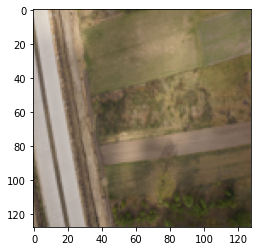

In [49]:
plt.imshow(valid_X[8])

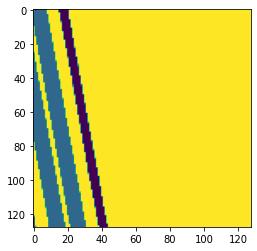

In [48]:
plt.imshow(valid_Y[8])

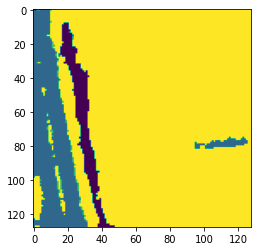

In [56]:
plt.imshow(create_mask(predicted[8]))

In [68]:
predicted = model.predict(create_masktrain_X)

NameError: name 'create_masktrain_X' is not defined

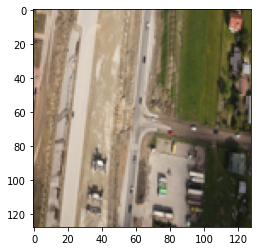

In [52]:
plt.imshow(train_X[100])

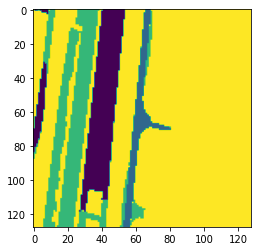

In [53]:
plt.imshow(train_Y[100])

In [54]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  return pred_mask

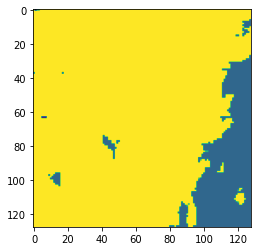

In [55]:
plt.imshow(create_mask(predicted[100]))

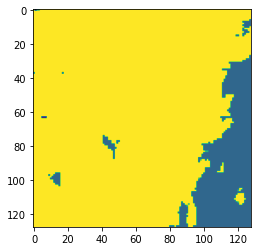

In [58]:
plt.imshow(create_mask(predicted[100]))

In [59]:
res = np.array(list(map(create_mask, predicted)))

In [60]:
predicted_test = model.predict(valid_X)

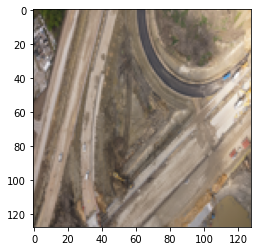

In [67]:
plt.imshow(valid_X[1])

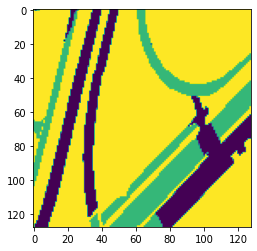

In [65]:
plt.imshow(valid_Y[1])


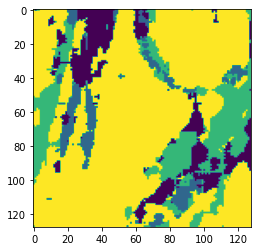

In [66]:
plt.imshow(create_mask(predicted_test[1]))